In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras


from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Reshape,LSTM
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten
from keras.layers import GlobalMaxPooling2D, Conv3D, MaxPooling3D, ConvLSTM2D, Add
from keras.models import Model
from keras.initializers import Constant
import tensorflow as tf

import pickle 

TEXT SECTION OF MODEL

In [ ]:
MAX_UTTERANCE_LENGTH = 20
MAX_NUM_WORDS = 20000

In [ ]:
#Load the data
pickle_text = open("X_dev_text_utterances.pickle","rb")
X_dev_text_utterances = pickle.load(pickle_text)

In [ ]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\x97\x92\x98\x85\x91')
tokenizer.fit_on_texts(X_dev_text_utterances)
X_dev_text_sequences = tokenizer.texts_to_sequences(X_dev_text_utterances)
X_dev_data_text = pad_sequences(X_dev_text_sequences, maxlen=MAX_UTTERANCE_LENGTH)

In [ ]:
X_dev_data_text.shape

(1102, 20)

In [ ]:
X_dev_embedding_matrix = open("X_dev_embedding.pickle","rb")
X_dev_embedding_matrix = pickle.load(X_dev_embedding_matrix)

In [ ]:
num_words = len(X_dev_embedding_matrix)
EMBEDDING_DIM = X_dev_embedding_matrix.shape[1]

In [ ]:
print(num_words)

1482


In [ ]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(X_dev_embedding_matrix),
                            input_length=MAX_UTTERANCE_LENGTH,
                            trainable=False)

In [ ]:
input_text_ = Input(shape = (MAX_UTTERANCE_LENGTH,), dtype = 'int32')
embedded_sequences = embedding_layer(input_text_)
output_text_ = Conv1D(64, 5, activation='relu')(embedded_sequences)
output_text_ = MaxPooling1D(2)(output_text_)
output_text_ = Conv1D(100, 5, activation='relu')(output_text_)
output_text_ = GlobalMaxPooling1D()(output_text_) #as in paper 100D textual features

model_text = Model(inputs = input_text_, outputs = output_text_)
model_text.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding (Embedding)       (None, 20, 300)           444600    
                                                                 
 conv1d (Conv1D)             (None, 16, 64)            96064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 100)            32100     
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                              

AUDIO SECTION OF MODEL

In [ ]:
#Load audio mfcc 40D features

pickle_audio_mfcc = open("X_dev_audio_mfcc.pickle","rb")
X_dev_audio_mfcc = pickle.load(pickle_audio_mfcc)

In [ ]:
X_dev_audio_mfcc = X_dev_audio_mfcc.reshape(1102, 10, 4)

In [ ]:
X_dev_audio_mfcc.shape

(1102, 10, 4)

In [ ]:
input_audio_ = Input(shape = (10, 4))
output_audio_ = Conv1D(16, 3, activation='relu')(input_audio_)
output_audio_ = MaxPooling1D(2)(output_audio_)
output_audio_ = Conv1D(32, 3, activation='relu')(output_audio_)
output_audio_ = MaxPooling1D(2)(output_audio_)
output_audio_ = Reshape((32,))(output_audio_)
# model_audio = Model(inputs = input_audio_, outputs = output_audio_)
# model_audio.summary()

CONCATENATE MODELS

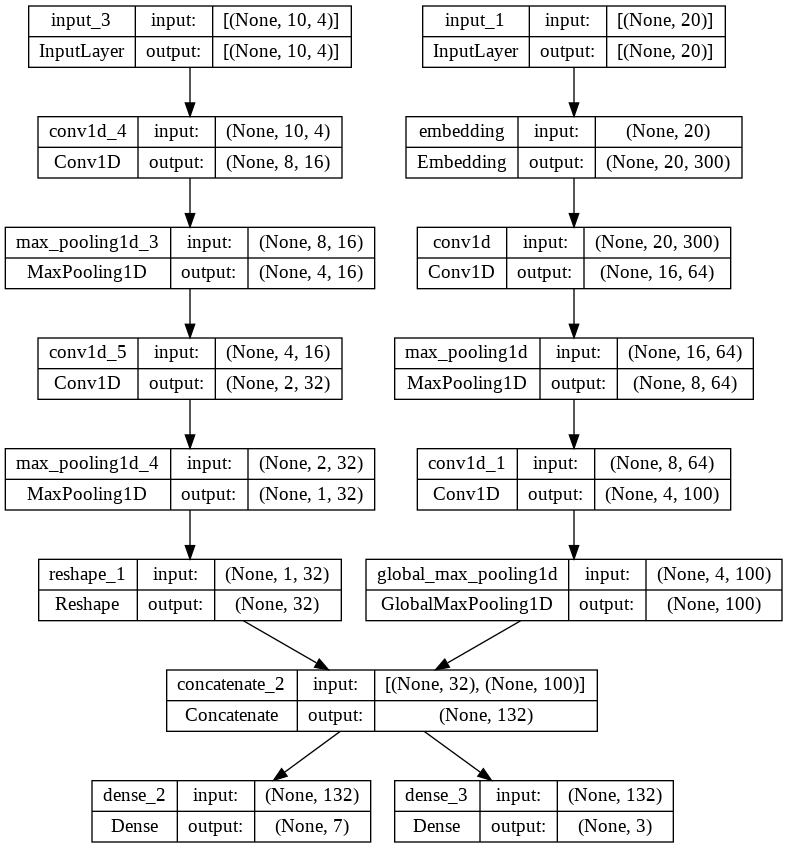

In [ ]:
#Concatenating the models to make multimodal
concatenate = Concatenate()([output_audio_, output_text_])
y_predict_emotions = Dense(7, activation='softmax')(concatenate)
y_predict_sentiments = Dense(3, activation='softmax')(concatenate)
model = Model(inputs=[input_audio_, input_text_], outputs=[y_predict_emotions, y_predict_sentiments])
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10, 4)]      0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 8, 16)        208         ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 20, 300)      444600      ['input_1[0][0]']                
                                                                                            

Y_Prediction : Label section of the model

In [ ]:
pickle_y_dev = open("Y_dev_float32.pickle","rb")
Y_dev_float32 = pickle.load(pickle_y_dev)

In [ ]:
Y_dev_float32_emotions = to_categorical(Y_dev_float32[:,0])   #keras.utils
Y_dev_float32_sentiments = to_categorical(Y_dev_float32[:,1])

print(Y_dev_float32_emotions.shape)
print(Y_dev_float32_sentiments.shape)

(1102, 7)
(1102, 3)


OPTIMIZATIONS

In [ ]:
#Optimizations => image for audio, separable conv, augmentation, dropout, who is the speaker in the dataset,
# Optimizers = adam, etc. (Study), optimize nn using keras tuner

DEFINE THE MODEL

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# log_dir= path + "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

filepath = "save_checkpoint/" + "final_weights_improvement-{epoch:02d}-{val_acc:3f}.hdf5"

early_stop = EarlyStopping(monitor = 'val_acc', min_delta = 0.001, patience = 10, mode = 'max', verbose = 1)
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

In [ ]:
# fit network
history = model.fit([Y_dev_float32_emotions, Y_dev_float32_sentiments],
                    epochs = 50,
                    batch_size=64,
                    validation_split=0.25,
                    callbacks = [early_stop])

In [ ]:
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()